# Phase 1 on METABRIC dataset

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

### Reading dataset

In [3]:
df = pd.read_csv("Data/METABRIC_RNA_Mutation.csv", usecols=range(31))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

### Percentage of missing values in each column

In [8]:
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
percent

tumor_stage                       0.263130
3-gene_classifier_subtype         0.107143
primary_tumor_laterality          0.055672
neoplasm_histologic_grade         0.037815
cellularity                       0.028361
mutation_count                    0.023634
er_status_measured_by_ihc         0.015756
type_of_breast_surgery            0.011555
tumor_size                        0.010504
cancer_type_detailed              0.007878
tumor_other_histologic_subtype    0.007878
oncotree_code                     0.007878
death_from_cancer                 0.000525
radio_therapy                     0.000000
lymph_nodes_examined_positive     0.000000
pr_status                         0.000000
overall_survival                  0.000000
overall_survival_months           0.000000
nottingham_prognostic_index       0.000000
patient_id                        0.000000
integrative_cluster               0.000000
inferred_menopausal_state         0.000000
age_at_diagnosis                  0.000000
her2_status

### Number of missing values

In [9]:
print(f"No of samples before dropping NaNs {df.shape[0]}, No of samples after dropping NaNs: {df.dropna().shape[0]}")

No of samples before dropping NaNs 1904, No of samples after dropping NaNs: 1092


### Standard form

In [10]:
def to_standard(df):
    
    num_df = df[df.select_dtypes(include = np.number).columns.tolist()]
    
    ss = StandardScaler()
    std = ss.fit_transform(num_df)
    
    std_df = pd.DataFrame(std, index = num_df.index, columns = num_df.columns)
    return std_df

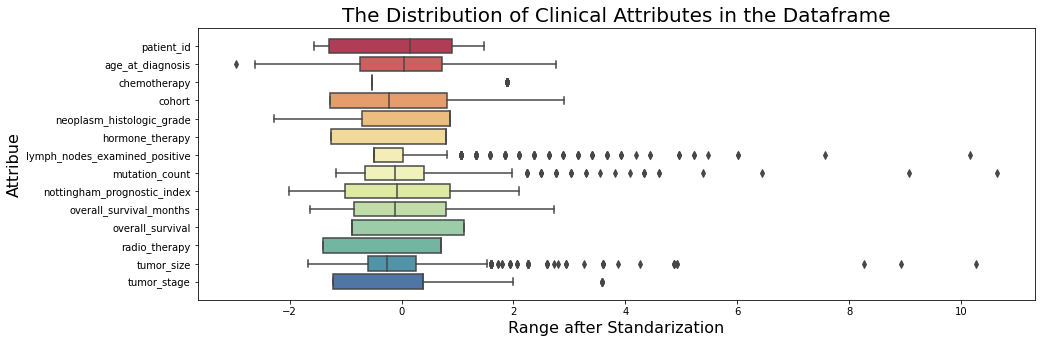

In [11]:
df = df.dropna()

ax, fig = plt.subplots(1, 1, figsize = (15, 5))
plt.title('The Distribution of Clinical Attributes in the Dataframe', fontsize = 20) #Change please

sns.boxplot(y = "variable", x = "value", data = pd.melt(to_standard(df)), palette = 'Spectral')
plt.xlabel('Range after Standarization', size = 16)
plt.ylabel('Attribue', size = 16)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [8]:
mask_df = (df[['tumor_size', 'mutation_count', 'lymph_nodes_examined_positive']].apply(zscore) < 3)
mask_df['Drop'] = True
for col in mask_df:
    mask_df['Drop'] &= mask_df[f"{col}"]
df_zscore = df[mask_df['Drop']]
print("df shape: ", df.shape)
print("df after zscore shape: ", df_zscore.shape)
print("Number of outliers that have been removed: ", df.shape[0]-df_zscore.shape[0])

df shape:  (1092, 31)
df after zscore shape:  (1034, 31)
Number of outliers that have been removed:  58


In [9]:
Q1 = df['tumor_size'].quantile(0.25)
Q3 = df['tumor_size'].quantile(0.75)
IQR = Q3 - Q1
filtered = df.query(f'(@Q1 - 1.5 * @IQR) <= tumor_size <= (@Q3 + 1.5 * @IQR)')
Q1 = filtered['mutation_count'].quantile(0.25)
Q3 = filtered['mutation_count'].quantile(0.75)
IQR = Q3 - Q1
filtered = filtered.query(f'(@Q1 - 1.5 * @IQR) <= mutation_count <= (@Q3 + 1.5 * @IQR)')
Q1 = filtered['lymph_nodes_examined_positive'].quantile(0.25)
Q3 = filtered['lymph_nodes_examined_positive'].quantile(0.75)
IQR = Q3 - Q1
df_IQR = filtered.query(f'(@Q1 - 1.5 * @IQR) <= lymph_nodes_examined_positive <= (@Q3 + 1.5 * @IQR)')
print("df shape: ", df.shape)
print("df after IQR shape: ", df_IQR.shape)
print("Number of outliers that have been removed: ", df.shape[0]-df_IQR.shape[0])

df shape:  (1092, 31)
df after IQR shape:  (901, 31)
Number of outliers that have been removed:  191


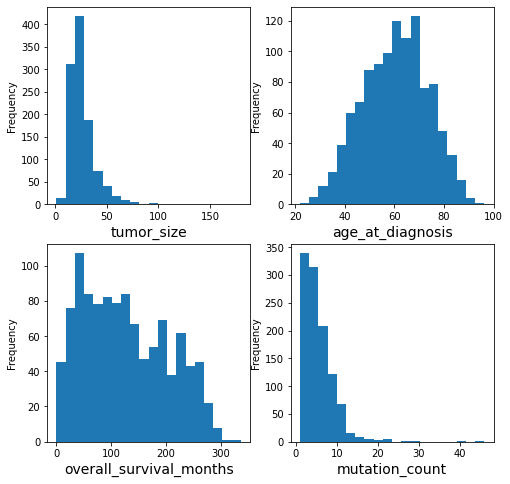

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

i, j = 0, 0
for col in df[['tumor_size', 'age_at_diagnosis', 'overall_survival_months', 'mutation_count']]:
    if j == 2:
        j = 0
        i = 1
    df[col].plot(kind='hist', bins=20, ax=ax[i, j])
    ax[i,j].set_xlabel(col, size=14)
    j += 1

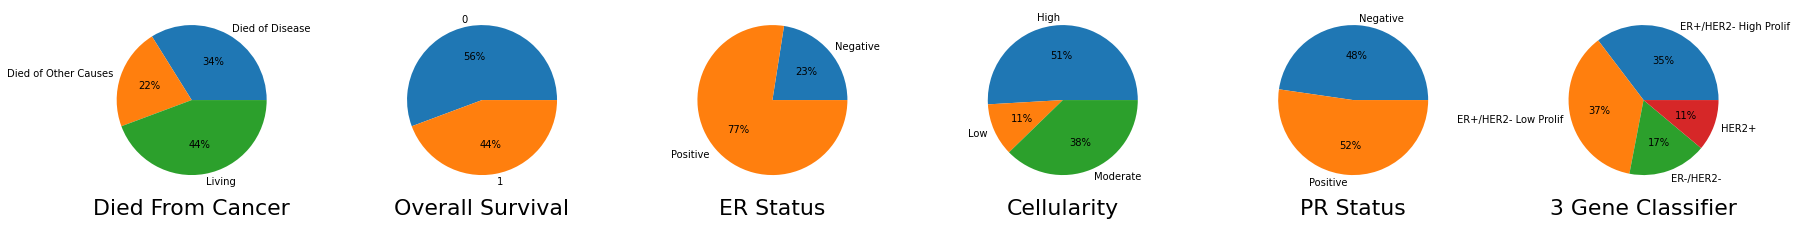

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, figsize=(25, 25))
df.groupby('death_from_cancer').size().plot(kind='pie', autopct='%1.0f%%', ax=ax1)
df.groupby('overall_survival').size().plot(kind='pie', autopct='%1.0f%%', ax=ax2)
df.groupby('er_status').size().plot(kind='pie', autopct='%1.0f%%', ax=ax3)
df.groupby('cellularity').size().plot(kind='pie', autopct='%1.0f%%', ax=ax4)
df.groupby('pr_status').size().plot(kind='pie', autopct='%1.0f%%', ax=ax5)
df.groupby('3-gene_classifier_subtype').size().plot(kind='pie', autopct='%1.0f%%', ax=ax6)

fig.patch.set_facecolor('xkcd:white')

ax1.set_xlabel('Died From Cancer', size=22)
ax2.set_xlabel('Overall Survival', size=22)
ax3.set_xlabel('ER Status', size=22)
ax4.set_xlabel('Cellularity', size=22)
ax5.set_xlabel('PR Status', size=22)
ax6.set_xlabel('3 Gene Classifier', size=22)
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
plt.tight_layout()
plt.show()

In [12]:
import jenkspy
columns = ['tumor_size', 'age_at_diagnosis', 'overall_survival_months', 'mutation_count']
for col in columns:
    breaks = jenkspy.jenks_breaks(df[col], nb_class=3)
    df[f'{col}_natural_breaks'] = pd.cut(df[col], bins=breaks, 
                                         labels=[f'{breaks[0]}, {breaks[1]}', f'{breaks[1]:.2f}, {breaks[2]:.2f}', f'{breaks[2]:.2f}, {breaks[3]:.2f}'], 
                                         include_lowest=True)

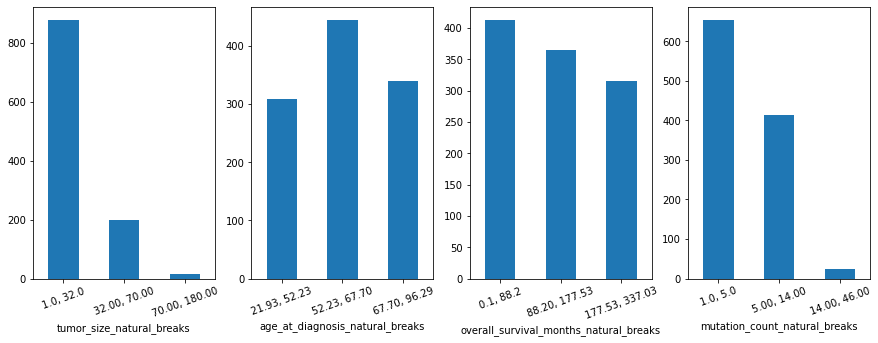

In [159]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 5))

columns = ['tumor_size_natural_breaks', 'age_at_diagnosis_natural_breaks', 'overall_survival_months_natural_breaks', 'mutation_count_natural_breaks']
j = 0
for col in columns:
    df.groupby(col).size().plot(kind='bar', ax=ax[j], rot=20)
    ax[j].set_xlabel(col, size=10)
    j+=1

In [117]:
to_standard(df)

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
1,-1.567516,-1.323860,-0.532162,-1.278292,0.871014,0.793631,-0.490800,-0.911111,-0.102808,-0.543610,1.120803,0.711482,-1.067942,-1.215941
4,-1.564638,1.275606,1.879128,-1.278292,0.871014,0.793631,1.587545,-0.911111,1.840645,-1.104789,-0.892218,0.711482,0.931303,0.385757
5,-1.563679,1.414121,-0.532162,-1.278292,0.871014,0.793631,-0.490800,-0.386219,-0.063184,-1.540157,-0.892218,0.711482,0.331529,3.589154
8,-1.555045,2.002041,-0.532162,-1.278292,0.871014,0.793631,-0.231006,-0.386219,0.851937,-1.167046,-0.892218,0.711482,-0.668093,0.385757
9,-1.551688,1.833514,-0.532162,-1.278292,-0.701130,-1.260031,-0.490800,-0.123773,-1.012269,-1.170937,-0.892218,-1.405517,0.131605,0.385757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,1.420676,0.833128,-0.532162,2.910440,-0.701130,0.793631,0.548373,1.450904,0.878353,-0.538854,-0.892218,-1.405517,0.264888,0.385757
1619,1.421156,0.789265,-0.532162,2.910440,-2.273275,-1.260031,-0.490800,0.926012,-1.970787,0.967855,1.120803,0.711482,-0.401527,-1.215941
1621,1.423074,1.171720,-0.532162,2.910440,0.871014,-1.260031,-0.490800,-0.386219,-0.083940,-0.276856,-0.892218,-1.405517,-0.401527,-1.215941
1623,1.424034,-0.581265,1.879128,2.910440,-0.701130,-1.260031,1.067959,-0.123773,0.859484,0.957046,1.120803,0.711482,-0.401527,0.385757
